In [123]:
import warnings
warnings.filterwarnings('ignore')
from sqlalchemy import (create_engine, Table, Column, Integer, String, MetaData, inspect)
import pandas as pd
import pymysql.cursors
import mysql.connector
import numpy as np
import math
import nltk
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn import mixture
%matplotlib inline

In [124]:
############ CONNECT TO THE DATABASE - OSX/Windows ############
# connection = pymysql.connect(host='localhost',
#                              user='root',
#                              password='root',#put your password for mysql server here.
#                              db='yelp_db',
#                              charset='utf8mb4',
#                              cursorclass=pymysql.cursors.DictCursor)

############ CONNECT TO THE DATABASE - RHEL ############
connection = mysql.connector.connect(
    user='root',
    password='root',
    host='127.0.0.1',
    port=3306,
    database='yelp_db')

trendy_data = pd.read_sql('''
select business.id,
  business.name,
  business.latitude,
  business.longitude,
  business.neighborhood,
  attribute.value
  from business
  right join category on business.id = category.business_id
  left join attribute on category.business_id = attribute.business_id
  where business.city = 'Pittsburgh'
  and category.category = 'Restaurants'
  and attribute.value LIKE '%"trendy": true%'
  order by business.neighborhood asc''',connection) #.values

upscale_data = pd.read_sql('''
select business.id,
  business.name,
  business.latitude,
  business.longitude,
  business.neighborhood,
  attribute.value
  from business
  right join category on business.id = category.business_id
  left join attribute on category.business_id = attribute.business_id
  where business.city = 'Pittsburgh'
  and category.category = 'Restaurants'
  and attribute.value LIKE '%"upscale": true%'
  order by business.neighborhood asc;''',connection)

romantic_data = pd.read_sql('''
select business.id,
  business.name,
  business.latitude,
  business.longitude,
  business.neighborhood,
  attribute.value
  from business
  right join category on business.id = category.business_id
  left join attribute on category.business_id = attribute.business_id
  where business.city = 'Pittsburgh'
  and category.category = 'Restaurants'
  and attribute.value LIKE '%"romantic": true%'
  order by business.neighborhood asc;''',connection)

classy_data = pd.read_sql('''
select business.id,
  business.name,
  business.latitude,
  business.longitude,
  business.neighborhood,
  attribute.value
  from business
  right join category on business.id = category.business_id
  left join attribute on category.business_id = attribute.business_id
  where business.city = 'Pittsburgh'
  and category.category = 'Restaurants'
  and attribute.value LIKE '%"classy": true%'
  order by business.neighborhood asc;''',connection)

# {"romantic": , "intimate": , "classy": ,
# "hipster": , "divey": , "touristy": ,
# "trendy": , "upscale": , "casual": }

divey_data = pd.read_sql('''
select business.id,
  business.name,
  business.latitude,
  business.longitude,
  business.neighborhood,
  attribute.value
  from business
  right join category on business.id = category.business_id
  left join attribute on category.business_id = attribute.business_id
  where business.city = 'Pittsburgh'
  and category.category = 'Restaurants'
  and attribute.value LIKE '%"divey": true%'
  order by business.neighborhood asc;''',connection)

touristy_data = pd.read_sql('''
select business.id,
  business.name,
  business.latitude,
  business.longitude,
  business.neighborhood,
  attribute.value
  from business
  right join category on business.id = category.business_id
  left join attribute on category.business_id = attribute.business_id
  where business.city = 'Pittsburgh'
  and category.category = 'Restaurants'
  and attribute.value LIKE '%"touristy": true%'
  order by business.neighborhood asc;''',connection)

casual_data = pd.read_sql('''
select business.id,
  business.name,
  business.latitude,
  business.longitude,
  business.neighborhood,
  attribute.value
  from business
  right join category on business.id = category.business_id
  left join attribute on category.business_id = attribute.business_id
  where business.city = 'Pittsburgh'
  and category.category = 'Restaurants'
  and attribute.value LIKE '%"casual": true%'
  order by business.neighborhood asc;''',connection)


In [125]:
#### assign values
upscaleDf = upscale_data[['latitude','longitude','neighborhood']]
upscaleDf['value'] = 'upscale'

trendyDf = trendy_data[['latitude','longitude','neighborhood']]
trendyDf['value'] = 'trendy'

diveyDf = divey_data[['latitude','longitude','neighborhood']]
diveyDf['value'] = 'divey'

touristyDf = touristy_data[['latitude','longitude','neighborhood']]
touristyDf['value'] = 'touristy'

casualDf = casual_data[['latitude','longitude','neighborhood']]
casualDf['value'] = 'casual'

romanticDf = romantic_data[['latitude','longitude','neighborhood']]
romanticDf['value'] = 'romantic'

classyDf = classy_data[['latitude','longitude','neighborhood']]
classyDf['value'] = 'classy'



## merge the dataframes
frames = [upscaleDf, trendyDf, diveyDf,casualDf,romanticDf, classyDf] #touristyDf
df = pd.concat(frames)
df.head()

,latitude,longitude,neighborhood,value
0,40.4891,-79.9007,Aspinwall,upscale
1,40.4807,-80.0415,Brighton Heights,upscale
2,40.4407,-80.0000,Downtown,upscale
3,40.4397,-79.9959,Downtown,upscale
4,40.4406,-79.9966,Downtown,upscale


In [126]:
df.neighborhood.value_counts() # there are 46 neighborhoods

                     254
Downtown             141
South Side            86
Oakland               77
Squirrel Hill         57
Shadyside             55
Strip District        50
Lawrenceville         49
Bloomfield            45
North Side            38
East Liberty          18
Dormont               16
Duquesne Heights      13
Mt. Washington        10
Beechview             10
The Hill District     10
West View              9
Greenfield             8
Garfield               8
West End               8
Highland Park          7
Greentree              6
Brookline              6
Aspinwall              6
Banksville             5
Brighton Heights       5
Troy Hill              5
Point Breeze           4
Regent Square          3
Millvale               3
Etna                   3
Allentown              3
Homewood               2
Emsworth               2
Carrick                2
Sharpsburg             2
Bon Air                2
Friendship             2
Bellevue               2
Larimer                2


In [127]:
df.value.value_counts()

casual      780
divey        89
trendy       88
classy       41
upscale      21
romantic     19
Name: value, dtype: int64

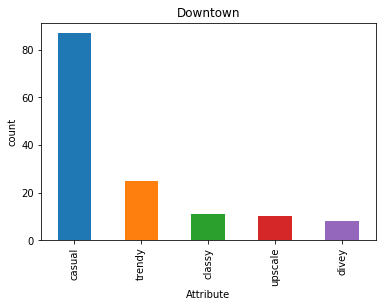

In [128]:
downtown = df.loc[df['neighborhood'] == 'Downtown']
p = downtown['value'].value_counts(sort=True).plot.bar()
p.set_title("Downtown")
p.set_xlabel("Attribute")
p.set_ylabel("count")

In [129]:
df['neighborhood'].replace('',0,inplace=True)
df['neighborhood'].replace('Downtown',1, inplace=True)
df['neighborhood'].replace('South Side',2, inplace=True)
df['neighborhood'].replace('Oakland',3, inplace=True)
df['neighborhood'].replace('Squirrel Hill',4, inplace=True)
df['neighborhood'].replace('Shadyside',5, inplace=True)
df['neighborhood'].replace('Strip District',6, inplace=True)
df['neighborhood'].replace('Lawrenceville',7, inplace=True)
df['neighborhood'].replace('Bloomfield',8, inplace=True)
df['neighborhood'].replace('North Side',9, inplace=True)
df['neighborhood'].replace('East Liberty',10, inplace=True)
df['neighborhood'].replace('Dormont',11, inplace=True)
df['neighborhood'].replace('Duquesne Heights',12, inplace=True)
df['neighborhood'].replace('Beechview',13, inplace=True)
df['neighborhood'].replace('Mt. Washington',15, inplace=True)
df['neighborhood'].replace('The Hill District',15, inplace=True)
df['neighborhood'].replace('West View ',16, inplace=True)
df['neighborhood'].replace('West End',17, inplace=True)
df['neighborhood'].replace('Garfield',18, inplace=True)
df['neighborhood'].replace('Greenfield',19, inplace=True)
df['neighborhood'].replace('Highland Park',20, inplace=True)
df['neighborhood'].replace('Brookline',21, inplace=True)
df['neighborhood'].replace('Aspinwall',22, inplace=True)
df['neighborhood'].replace('Greenfield',23, inplace=True)
df['neighborhood'].replace('Troy Hill',24, inplace=True)
df['neighborhood'].replace('Brighton Heights',25, inplace=True)
df['neighborhood'].replace('Banksville',26, inplace=True)
df['neighborhood'].replace('Point Breeze',27, inplace=True)
df['neighborhood'].replace('Allentown',28, inplace=True)
df['neighborhood'].replace('Regent Square',29, inplace=True)
df['neighborhood'].replace('Etna',30, inplace=True)
df['neighborhood'].replace('Millvale',31, inplace=True)
df['neighborhood'].replace('Sharpsburg',32, inplace=True)
df['neighborhood'].replace('Emsworth',33, inplace=True)
df['neighborhood'].replace('Larimer',34, inplace=True)
df['neighborhood'].replace('Carrick',35, inplace=True)
df['neighborhood'].replace('Bellevue',36, inplace=True)
df['neighborhood'].replace('Friendship',37, inplace=True)
df['neighborhood'].replace('Homewood',38, inplace=True)
df['neighborhood'].replace('Bon Air',39, inplace=True)
df['neighborhood'].replace('Overbrook',40, inplace=True)
df['neighborhood'].replace('Avalon',41, inplace=True)
df['neighborhood'].replace('Hazelwood',42, inplace=True)
df['neighborhood'].replace('West View',43, inplace=True)
df['neighborhood'].replace('Greentree',44, inplace=True)
df['neighborhood'].replace('Homestead',45, inplace=True)

In [130]:
# drop all the neighborhoods except downtown
df = df[df.neighborhood != 0]

df = df[df.neighborhood != 2]
df = df[df.neighborhood != 3]
df = df[df.neighborhood != 4]
df = df[df.neighborhood != 5]
df = df[df.neighborhood != 6]
df = df[df.neighborhood != 7]
df = df[df.neighborhood != 8]
df = df[df.neighborhood != 9]
df = df[df.neighborhood != 10]
df = df[df.neighborhood != 11]
df = df[df.neighborhood != 12]
df = df[df.neighborhood != 13]
df = df[df.neighborhood != 14]
df = df[df.neighborhood != 15]
df = df[df.neighborhood != 16]
df = df[df.neighborhood != 17]
df = df[df.neighborhood != 18]
df = df[df.neighborhood != 19]
df = df[df.neighborhood != 20]
df = df[df.neighborhood != 21]
df = df[df.neighborhood != 22]
df = df[df.neighborhood != 23]
df = df[df.neighborhood != 24]
df = df[df.neighborhood != 25]
df = df[df.neighborhood != 26]
df = df[df.neighborhood != 27]
df = df[df.neighborhood != 28]
df = df[df.neighborhood != 29]
df = df[df.neighborhood != 30]
df = df[df.neighborhood != 31]
df = df[df.neighborhood != 32]
df = df[df.neighborhood != 33]
df = df[df.neighborhood != 34]
df = df[df.neighborhood != 35]
df = df[df.neighborhood != 36]
df = df[df.neighborhood != 37]
df = df[df.neighborhood != 38]
df = df[df.neighborhood != 39]
df = df[df.neighborhood != 40]
df = df[df.neighborhood != 41]
df = df[df.neighborhood != 42]
df = df[df.neighborhood != 43]
df = df[df.neighborhood != 44]
df = df[df.neighborhood != 45]

In [131]:
df.neighborhood.value_counts()

1    141
Name: neighborhood, dtype: int64

In [132]:
df.value.value_counts()

casual     87
trendy     25
classy     11
upscale    10
divey       8
Name: value, dtype: int64

In [133]:
new_dfh = df[['latitude','longitude']].copy()

In [134]:
df = df[['latitude','longitude','value','neighborhood']].copy() 
df[['latitude','longitude']] = (df[['latitude','longitude']].sub(df[['latitude','longitude']].mean())).divide(df[['latitude','longitude']].std())

topDf = df.copy()
categoryList = df['value'].tolist()

def topCategories(categoryList):
    n = []
    for i in categoryList:
         n += [i.split(',')]   
    count={}
    for i in n:
        for j in i:
            if j not in count:
                count[j]=1
            else:
                count[j] = count[j] +1
    return OrderedDict(sorted(count.items(), key=lambda a:a[1], reverse=True))    

def convert(j):
    for i in top:
        if(i == j):
            return(top.index(i)+1)
        
top = list(topCategories(categoryList))[0:15]
topCatNames=[]
topCatNames = top
c =[]
for i in df['value']:
    row = i.split(',')
    c += [[convert(j) for j in row if j in top]]
topDf['value'] = c
topDf = topDf.reset_index(drop = True)
a = np.zeros(shape=(len(topDf['value']),15))
i=0
for j in c:
    for k in j:
        a[i,k-1]=1
    i+=1
top = pd.DataFrame.from_records(a)
top[['latitude','longitude']] = topDf[['latitude','longitude']]

#print(top)

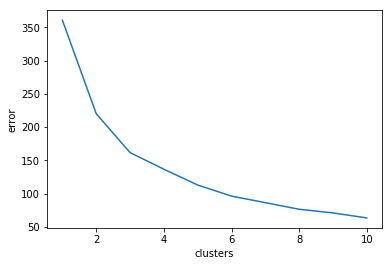

In [135]:
# evaluate the clusters
n = 11 # max clusters
error = np.zeros(n)
error[0] = 0;
for k in range(1,n):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
    kmeans.fit_predict(top)
    error[k] = kmeans.inertia_
plt.figure(1)
plt.plot(range(1,len(error)),error[1:])
plt.xlabel('clusters')
plt.ylabel('error')
plt.savefig('error_kmeans_attributes.pdf', bbox_inches='tight')

In [136]:
kmeans = KMeans(init='k-means++', n_clusters=3, n_init=100) 
km = kmeans.fit_predict(top)
labels = kmeans.labels_

silhouette_score(top, labels, metric='euclidean')

0.34855178131361264

In [137]:
from sklearn import metrics
metrics.calinski_harabaz_score(top, labels) 

85.109715143509163

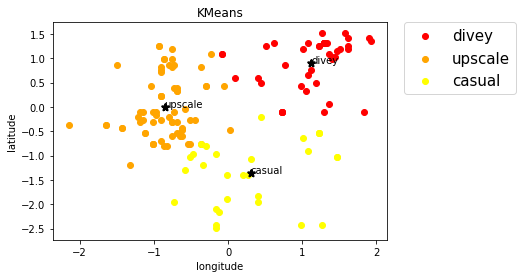

In [138]:
def createCentroids(centroids):
    y = 0  
    for i in centroids:
        plt.scatter(i[16],i[15],s=50,c='black',marker='*',linewidth=2)
        plt.annotate(labelsKm[y],xy=(i[16],i[15]))
        y+=1
    
def createScatter(clusters):
    colors = ['red','orange','yellow','green','blue','purple']
    x = 0
    for i in clusters:
        for j in i:
            plt.scatter(top['longitude'][j],top['latitude'][j], color=colors[x]) #org: lat, long
        x=x+1
        
def labels(cluster):
    count = {}
    for i in cluster[0]:
        for j in topDf['value'][i]:
            if j not in count:
                count[j] = 1
            else:
                count[j] +=1
    return OrderedDict(sorted(count.items(), key=lambda kv:kv[1], reverse=True))

def clusterLabel(lc,topCounts):
    maxx = 0
    index=0
    for key,value in lc.items():
        temp = value/topCounts[key-1]
        if(temp>maxx):
            maxx = temp
            index = key-1
    return topCatNames[index]

topCounts = list(topCategories(categoryList).values())[0:15]
labelsKm = []
km0 = np.where(km==0)
lc = labels(km0)
labelsKm.append(clusterLabel(lc, topCounts))
km1 = np.where(km==1)
lc = labels(km1)
labelsKm.append(clusterLabel(lc, topCounts))

km2 = np.where(km==2)
lc = labels(km2)
labelsKm.append(clusterLabel(lc, topCounts))

# km3 = np.where(km==3)
# lc = labels(km3)
# labelsKm.append(clusterLabel(lc, topCounts))

# km4 = np.where(km==4)
# lc = labels(km4)
# labelsKm.append(clusterLabel(lc, topCounts))

# km5 = np.where(km==5)
# lc = labels(km5)
# labelsKm.append(clusterLabel(lc, topCounts))


clusters = [km0,km1,km2]
createScatter(clusters)
createCentroids(kmeans.cluster_centers_)

plt.title('KMeans')
plt.xlabel('longitude') # latitude
plt.ylabel('latitude')
legend = plt.legend([labelsKm[i] for i in range(len(labelsKm))],bbox_to_anchor=(1.05, 1),
                    loc=2, borderaxespad=0.,fontsize=15)

plt.savefig('kmeans_attributes.pdf', bbox_extra_artists=(legend,), bbox_inches='tight')
plt.show()

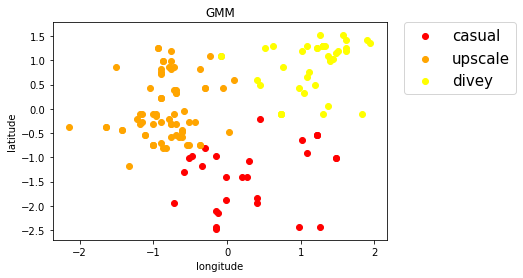

In [139]:
labelsGmm=[]
gmm = mixture.GMM(n_components=3,covariance_type='spherical')
gmm.fit(top)
gaussian = gmm.predict(top)
g0 = np.where(gaussian==0)
x= labels(g0)
labelsGmm.append(clusterLabel(x, topCounts))
g1 = np.where(gaussian==1)
x= labels(g1)
labelsGmm.append(clusterLabel(x, topCounts))
g2 = np.where(gaussian==2)
x= labels(g2)
labelsGmm.append(clusterLabel(x, topCounts))


clustersGmm = [g0,g1,g2] 
createScatter(clustersGmm)
plt.title('GMM')
plt.xlabel('longitude') #latitude
plt.ylabel('latitude') #longitude
legend = plt.legend([labelsGmm[i] for i in range(len(labelsGmm))],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=15)
plt.show()